# ECE 417 Lecture 20: Hidden Markov Models
## Mark Hasegawa-Johnson, November 2, 2017
This file is distributed under a <a href="https://creativecommons.org/licenses/by/3.0/">CC-BY</a> license.  You may freely re-use or re-distribute the whole or any part.  If you re-distribute a non-trivial portion of it, give me credit.

## Outline of Today's lecture
* Defining an HMM
* Generating data from an HMM
* Initializing the parameters
* Re-estimating parameters: The forward-backward algorithm
* The scaled forward-backward algorithm


# Preliminaries
First let's load some libraries, and some data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import requests
%matplotlib inline

# Defining an HMM
A diagonal covariance Gaussian Hidden Markov model (an HMM with diagonal covariance Gaussian observation probabilities) is defined by four sets of parameters:
$$\pi_i=\Pr\left\{q_1=i\right\}$$
$$a_{ij}=\Pr\left\{q_{t+1}=j|q_t=i\right\}$$
$$\mu_{di}=E\left[x_{dt}|q_t=i\right]$$
$$\sigma_{di}^2=E\left[(x_{dt}-\mu_{di})^2|q_t=i\right]$$
In this lecture I will generate data using the true values of each parameter, and then try to recognize data using estimated values of each parameter. Let's assume a three-state HMM.
* For simplicity, let's set $\pi_i=\delta[i-1]$, so the HMM always starts in state 1.
* Let's use a left-to-right HMM: $a_{ij}=0$ unless $j\in\left\{i,i+1\right\}$.  In particular, let's use $a_{ii}=0.8$, so that the HMM is expected to stay in each state for five frames.
* Let's use a 12-dimensional observation vector.  Its mean vector will be different in each state.
* Let's use a variance vector which has the same variance in every dimension, but with higher variance in the middle state.

In [2]:
states = [0,1,2,3]
N = len(states)-1 # Define N as the number of emitting states
pi_true = [1,0,0,0]
A_true = [[0.8,0.2,0,0],[0,0.8,0.2,0],[0,0,0.8,0.2]]
mu_true = [[2,2,2,2,0,0,0,0,0,0,0,0],[0,0,0,0,2,2,2,2,0,0,0,0],[0,0,0,0,0,0,0,0,2,2,2,2]]
sigsq_true = [[1,1,1,1,1,1,1,1,1,1,1,1],[2,2,2,2,2,2,2,2,2,2,2,2],[1,1,1,1,1,1,1,1,1,1,1,1]]


# Generating data from an HMM
Now let's run the HMM.  We'll generate a state $q$, then generate a vector $\vec{x}$ from it.  Then repeat this process until $q=3$, at which point we stop.

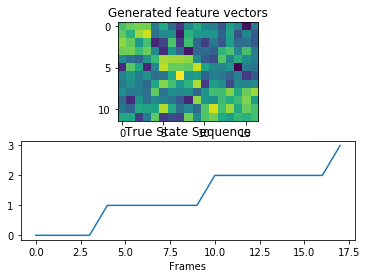

In [9]:
Q = list(np.random.choice(states,1,p=pi_true))
q = Q[-1]
X = []
while q < 3:
    xt = stats.multivariate_normal.rvs(mean=mu_true[q],cov=np.diag(sigsq_true[q]))
    X.append(xt)
    Q.extend(np.random.choice(states,1,p=A_true[q]))
    q = Q[-1]


plt.subplot(211)
plt.imshow(np.transpose(X))
plt.title('Generated feature vectors')
plt.subplot(212)
plt.plot(Q)
plt.xlabel('Frames')
plt.title('True State Sequence')

# Estimating the parameters of an HMM
Now let's create estimated parameters.  In order to create the initial estimate,
we'll just divide the training example into thirds.  
* pi: We'll assume we know this
* A: We'll estimate this by estimating the duration of each state to be $d=T/3$, and then choosing the transition probability $a_{i,i+1}=1/d$.  That's the transition probability such that the expected duration of the state is $d$.
* $\mu$, $\sigma^2$: We'll estimate these parameters as the mean and the variance, respectively, of each one-third of the given training example.


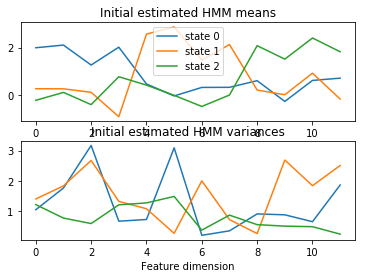

In [10]:
pi=[1,0,0,0]
T=len(X)
d=int(T/3)
a=1/d
A=[[1-a,a,0,0],[0,1-a,a,0],[0,0,1-a,a]]
mu=[np.average(X[0:d],axis=0),np.average(X[d:2*d],axis=0),np.average(X[2*d:T],axis=0)]
sigsq=[np.var(X[0:d],axis=0),np.var(X[d:2*d],axis=0),np.var(X[2*d:T],axis=0)]
plt.subplot(211)
plt.plot(np.transpose(mu))
plt.legend(['state 0','state 1','state 2'])
plt.title('Initial estimated HMM means')
plt.subplot(212)
plt.plot(np.transpose(sigsq))
plt.title('Initial estimated HMM variances')
plt.xlabel('Feature dimension')

Now we'll compute the forward-backward algorithm using these initial estimates.  First we compute B, a matrix whose $(i,t)^{\textrm{th}}$ element is $p(\vec{x}_t|q_t=i)$.

### E-step part 1
$$b_i(\vec{x}_t)=p(\vec{x}_t|q_t=i)=\frac{1}{(2\pi)^{D/2}|\Sigma_i|^{1/2}}e^{-\frac{1}{2}(\vec{x}_t-\vec\mu_{i})^T\Sigma_i^{-1}(\vec{x}_t-\vec\mu_i)}$$
for diagonal covariance Gaussians, that's
$$b_i(\vec{x}_t)=\prod_{d=1}^{12} \frac{1}{\sqrt{2\pi\sigma_i^2}}e^{-\frac{1}{2}\left(\frac{x_{dt}-\mu_{di}}{\sigma_i}\right)^2}$$

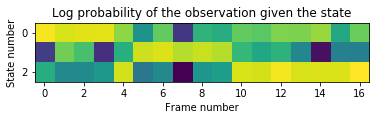

In [18]:
B=np.zeros((N,T))
for t in range(0,T):
    for i in range(0,N):
        B[i,t]=stats.multivariate_normal(mu[i],np.diag(sigsq[i])).pdf(X[t])
plt.imshow(np.log(B))
plt.title('Log probability of the observation given the state')
plt.xlabel('Frame number')
plt.ylabel('State number')


### E-Step part 2
Now we compute alpha, beta, gamma, and xi.
$$\alpha_0(i)=\Pr\left\{q_0=i,\vec{x}_0\right\}=\pi_i b_i(\vec{x}_0)$$
$$\alpha_t(i)=\Pr\left\{q_t=i,\vec{x}_0,\ldots,\vec{x}_t\right\}=b_i(\vec{x}_t)\sum_{j=0}^{N-1}\alpha_{t-1}(j)a_{ji}$$
$$\beta_{T-1}(i)=1$$
$$\beta_{t}(i)=\Pr\left\{\vec{x}_{t+1},\ldots,\vec{x}_{T-1}|q_t=i\right\}=\sum_{j=0}^{N-1}a_{ij}b_j(\vec{x}_{t+1})\beta_{t+1}(j)$$
$$\gamma_t(i)=\Pr\left\{q_t=i|\vec{x}_0,\ldots,\vec{x}_{T-1}\right\}=\frac{\alpha_t(i)\beta_t(i)}{\sum_{j=0}^{N-1}\alpha_t(j)\beta_t(j)}$$
$$\xi_t(i,j)=\Pr\left\{q_t=i,q_{t+1}=j|\vec{x}_0,\ldots,\vec{x}_{T-1}\right\}=\frac{\alpha_t(i)a_{ij}b_j(\vec{x}_{t+1})\beta_{t+1}(j)}{\sum_{i=0}^{N-1}\sum_{j=0}^{N-1}\alpha_t(i)a_{ij}b_j(\vec{x}_{t+1})\beta_{t+1}(j)}$$

Notice that, since $a_{ij}=0$ except for $j\in\left\{i,i+1\right\}$, therefore $\xi_t(i,j)=0$ except for $j\in\left\{i,i+1\right\}$.  Therefore we can save a little space in computations by computing $\xi_t(i,j)$ only for those two possibilities.

C:\Users\jhasegaw\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log


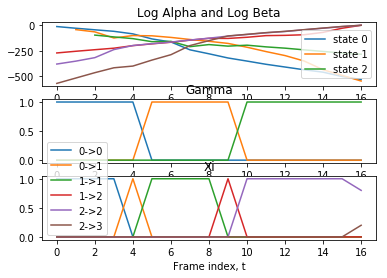

In [19]:
alpha = np.zeros((N,T))
beta = np.zeros((N,T))
gamma = np.zeros((N,T))
xi = np.zeros((2*N,T))
Amat = np.array(A)  # Convert to an np matrix so we can compute inner products
for i in range(0,N):
    alpha[i,0]=pi[i]*B[i,0]
for t in range(1,T):
    for i in range(0,N):
        alpha[i,t]=B[i,t]*np.inner(alpha[:,t-1],Amat[:,i])
for i in range(0,N):
    beta[i,T-1]=1
for t in range(T-2,-1,-1):
    for i in range(0,N):
        beta[i,t]=np.inner(Amat[i,0:N],beta[:,t+1]*B[:,t+1])
for t in range(0,T):
    gamma[:,t]=alpha[:,t]*beta[:,t]
    gamma[:,t]=gamma[:,t]/np.sum(gamma[:,t])
for t in range(0,T):
    for i in range(0,N):
        for j in range(i,i+2):
            xi[i+j,t]=alpha[i,t]*Amat[i,j]
            if (t<T-1):
                if j==N:
                    xi[i+j,t]=0
                else:
                    xi[i+j,t] = xi[i+j,t]*B[j,t+1]*beta[j,t+1]
    xi[:,t]=xi[:,t]/np.sum(xi[:,t])
    
plt.subplot(311)
plt.plot(range(0,T),np.transpose(np.log(alpha)),range(0,T),np.transpose(np.log(beta)))
plt.title('Log Alpha and Log Beta')
plt.legend(['state 0','state 1','state 2'])
plt.subplot(312)
plt.plot(np.transpose(gamma))
plt.title('Gamma')
plt.subplot(313)
plt.plot(np.transpose(xi))
plt.legend(['0->0','0->1','1->1','1->2','2->2','2->3'])
plt.title('Xi')
plt.xlabel('Frame index, t')


### M-Step for multiple files
If you have multiple files, then you compute for example $\gamma_{t\ell}(i)$ for the $t^{th}$ frame of the $\ell^{th}$ file
$$a_{ij}=\frac{\sum_\ell\sum_t \xi_{t\ell}(i,j)}{\sum_\ell\sum_t\gamma_{t\ell}(i)}\approx \Pr\left\{q_{t+1}=j|q_t=i\right\}$$
$$\vec\mu_i=\frac{\sum_\ell\sum_t\gamma_{t\ell}(i)\vec{x}_t}{\sum_\ell\sum_t\gamma_{t\ell}(i)}\approx E\left[\vec{x}_{t}|q_t=i\right]$$
$$\sigma_{di}^2=\frac{\sum_\ell\sum_t\gamma_{t\ell}(i)(x_{dt}-\mu_{di})^2}{\sum_\ell\sum_t\gamma_{t\ell}(i)}\approx E\left[(x_{dt}-\mu_{di})^2|q_t=i\right]$$

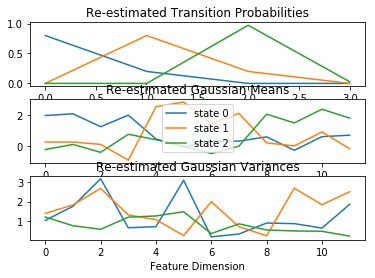

In [20]:
for i in range(0,N):
    for j in range(i,i+2):
        A[i][j]=np.sum(xi[i+j,:])/np.sum(gamma[i,:])
for i in range(0,N):
    mu[i] = np.inner(np.transpose(X),gamma[i,:])/np.sum(gamma[i,:])
for i in range(0,N):
    sigsq[i]=np.inner(np.transpose(X-mu[i])**2,gamma[i,:])/np.sum(gamma[i,:])
plt.subplot(311)
plt.plot(np.transpose(A))
plt.title('Re-estimated Transition Probabilities')
plt.subplot(312)
plt.plot(np.transpose(mu))
plt.title('Re-estimated Gaussian Means')
plt.legend(['state 0','state 1','state 2'])
plt.subplot(313)
plt.plot(np.transpose(sigsq))
plt.title('Re-estimated Gaussian Variances')
plt.xlabel('Feature Dimension')

### Iterating the EM algorithm
In real life, we would iterate the above algorithm several times between the E-step and the M-step.  We won't do that today.

### M-Step
Now we re-estimate the means, variances, and transition probabilities
$$a_{ij}=\frac{\sum_t \xi_t(i,j)}{\sum_t\gamma_t(i)}\approx \Pr\left\{q_{t+1}=j|q_t=i\right\}$$
$$\vec\mu_i=\frac{\sum_t\gamma_t(i)\vec{x}_t}{\sum_t\gamma_t(i)}\approx E\left[\vec{x}_{t}|q_t=i\right]$$
$$\sigma_{di}^2=\frac{\sum_t\gamma_t(i)(x_{dt}-\mu_{di})^2}{\sum_t\gamma_t(i)}\approx E\left[(x_{dt}-\mu_{di})^2|q_t=i\right]$$

# Scaled EM
You might have noticed that $\alpha_t(i)$ keeps getting smaller and smaller as you go further to the right.  That's because the Gaussian pdf can be either bigger or smaller than 1.0, but usually it's much smaller.

Suppose that $b_j(\vec{x}_t)$ is typically around $0.001$.  Then $\alpha_t(i)\sim 10^{-3t}\sim 2^{-30t}$.  Standard IEEE double-precision floating point can represent numbers as small as $2^{-1022}$, which means that you can compute the forward-backward algorithm for an audio file of at most $T\le 1022/30=34$ frames.  The problem is much worse on fixed-point embedded processors (obviously).

The solution is to scale $\alpha_t(i)$ and $\beta_t(i)$.  As long as we scale them by the same amount, then we can compute $\gamma_t(i)$ without any special re-normalizing.  It works like this:
$$\tilde{\alpha}_t(i)=\frac{\alpha_t(i)}{\prod_{\tau=1}^t g_\tau}$$
$$\tilde{\beta}_t(i)=\frac{\beta_t(i)}{\prod_{\tau=t+1}^T g_\tau}$$
$$\gamma_t(i)=\frac{\alpha_t(i)\beta_t(i)}{\sum_{j=0}^{N-1}\alpha_t(j)\beta_t(j)}$$
$$=\frac{\frac{\alpha_t(i)\beta_t(i)}{\prod_{\tau=1}^T g_\tau}}{\frac{\sum_{j=0}^{N-1}\alpha_t(j)\beta_t(j)}{\prod_{\tau=1}^T g_\tau}}$$
$$=\frac{\tilde{\alpha}_t(i)\tilde{\beta}_t(i)}{\sum_{j=0}^{N-1}\tilde{\alpha}_t(j)\tilde{\beta}_t(j)}$$

So any scaling constant $g_t$ will work, AS LONG AS YOU USE THE SAME $g_t$ FOR BOTH ALPHA AND BETA!!!

Here's a pretty reasonable choice:
$$\bar\alpha_t(i)=b_i(\vec{x}_t)\sum_{j=0}^{N-1}\tilde{\alpha}_{t-1}(j)a_{ji}$$
$$g_t=\sum_{i=0}^{N-1}\bar\alpha_t(i)$$
$$\tilde\alpha_t(i) = \frac{1}{g_t}\bar\alpha_t(i)$$

If you work through it, you discover that, with this choice,
$$\prod_{t=1}^T g_t = \sum_{j=0}^{N-1}\alpha_T(j)$$

But you might remember that $\sum_{j=0}^{N-1}\alpha_T(j)$ is actually the probability of the data sequence, $X$, given the model parameters $\Lambda$.  So
$$p(X|\Lambda)=\sum_{j=0}^{N-1}\alpha_T(j)=\prod_{t=1}^T g_t$$
$$\ln p(X|\Lambda)=\sum_{t=1}^{T}\ln g_t$$

So we don't need to store $g_t$, just $\ln g_t$.

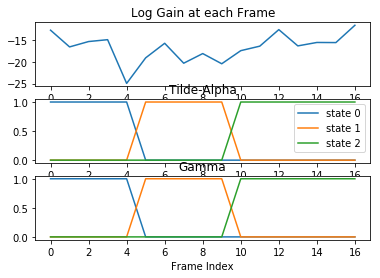

In [23]:
tildealpha=np.zeros((N,T))
tildebeta=np.zeros((N,T))
log_g = np.zeros((T))
baralpha = np.zeros((N,T))
Amat = np.array(A)

for i in range(0,N):
    baralpha[i,0]=pi[i]*B[i,0]
log_g[0] = np.log(np.sum(baralpha[:,0]))
tildealpha[:,0]=baralpha[:,0]/np.exp(log_g[0])

for t in range(1,T):
    for i in range(0,N):
        baralpha[i,t]=B[i,t]*np.inner(tildealpha[:,t-1],Amat[:,i])
    log_g[t] = np.log(np.sum(baralpha[:,t]))
    tildealpha[:,t]=baralpha[:,t]/np.exp(log_g[t])

for i in range(0,N):
    tildebeta[i,T-1] = 1/np.exp(log_g[T-1])

for t in range(T-2,-1,-1):
    for i in range(0,N):
        tildebeta[i,t]=np.inner(Amat[i,0:N],tildebeta[:,t+1]*B[:,t+1])/np.exp(log_g[t+1])

for t in range(0,T):
    gamma[:,t] = tildealpha[:,t]*tildebeta[:,t]
    gamma[:,t] = gamma[:,t]/np.sum(gamma[:,t])
    
plt.subplot(311)
plt.plot(log_g)
plt.title('Log Gain at each Frame')
plt.subplot(312)
plt.plot(np.transpose(tildealpha))
plt.title('Tilde-Alpha')
plt.legend(['state 0','state 1','state 2'])
plt.subplot(313)
plt.plot(np.transpose(gamma))
plt.title('Gamma')
plt.xlabel('Frame Index')
